<a href="https://colab.research.google.com/github/Goro-python/my_NLP/blob/next_dev/ColaBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# keras Tuner 
import tensorflow as tf
from keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np

import pandas as pd


from sklearn.metrics import precision_score,recall_score,confusion_matrix
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

import datetime, os

deviceName = tf.test.gpu_device_name()
print(deviceName)

%matplotlib inline

/device:GPU:0


In [2]:
#!pip uninstall tensorflow

In [3]:
#!pip install tensorflow==2.3.0

In [4]:
tf.__version__

'2.3.0'

In [5]:
#!pip install wget

In [5]:
# loading cola data 

# Original COLA train dataset
# Data download for COLA 
import wget
import os

print("Downloading the dataset ......")
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

# unzipping the data
if not os.path.exists("./cola_public/"):
    !unzip cola_public_1.1.zip

filePath = "./cola_public/raw/in_domain_train.tsv"
df_train = pd.read_csv(filePath, delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df_train.sample(10)


,sentence_source,label,label_notes,sentence
5167,ks08,1,NaN,Tom ate what Mary offered to him.
4771,ks08,1,NaN,John put the books in a box.
2551,l-93,0,*,Cheryl stood the shelf with books.
8133,ad03,1,NaN,Lee's youngest and Dawn's oldest son ran away.
6960,m_02,1,NaN,The Minister has arrived.
3539,ks08,0,*,They can happy.
2961,l-93,1,NaN,Sandy sang a song.
5270,b_82,1,NaN,John is certain that the Mets will win.
5768,c_13,1,NaN,"Although he loves marshmallows, John is not a ..."
1552,r-67,1,NaN,"Tom washed, and Dick waxed, and Harry polished..."


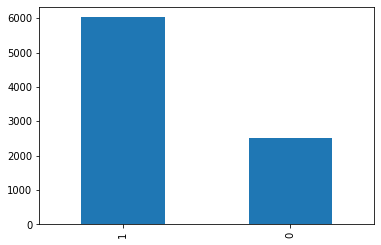

In [6]:
df_train["label"].value_counts().plot.bar()

In [8]:
imbalance_fact = 5.0

In [9]:
# creating the imbalance data 
pos = df_train[df_train["label"]==1]
neg = df_train[df_train["label"]==0]
print(pos.shape[0]//imbalance_fact)
newNeg =  neg.sample(int(pos.shape[0]//imbalance_fact))
df_train_imb = pd.concat([pos,newNeg])

1204.0


In [10]:
# COLA Test set 
filePath = "./cola_public/raw/in_domain_dev.tsv"
df_test = pd.read_csv(filePath, delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df_test.sample(10)

,sentence_source,label,label_notes,sentence
445,sks13,1,NaN,It was from six to nine or it took place from ...
37,bc01,1,NaN,We persuaded Mary to leave and Sue to stay.
211,l-93,1,NaN,The stream twists through the valley.
4,cj99,0,*,"As you eat the most, you want the least."
487,ad03,1,NaN,Anson demonized David every day
202,l-93,0,*,My heart is pounding me.
476,ad03,1,NaN,You kicked yourselves
29,bc01,0,*,The tube was escaped by gas.
225,ks08,0,*,Some my jobs are in jeopardy.
48,bc01,1,NaN,I remembered having kissed Mary.


In [26]:
# test Set 
pos = df_test[df_test["label"]==1]
neg = df_test[df_test["label"]==0]
print(pos.shape[0]//imbalance_fact)
newNeg =  neg.sample(int(pos.shape[0]//imbalance_fact))
df_test_imb = pd.concat([pos,newNeg])

73.0


In [27]:
# COLA Dataset train dataset 
cola_x_train = df_train_imb["sentence"].to_numpy()
cola_y_train = df_train_imb["label"].to_numpy()
vocabSize = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=vocabSize,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token=None)
tokenizer.fit_on_texts(cola_x_train)
cola_tensor = tokenizer.texts_to_sequences(cola_x_train)

maxLength = max([len(c) for c in cola_tensor])
print("Cola current sample max length : ",maxLength)

maxLen = 40
cola_tensor = tf.keras.preprocessing.sequence.pad_sequences(cola_tensor,maxlen = maxLen,
                                                         padding='post')

cola_x_train =  cola_tensor

Cola current sample max length :  42


In [28]:
cola_x_train.shape

(7227, 40)

In [29]:
# COLA test dataset
cola_x_test = df_test_imb["sentence"].to_numpy()
cola_y_test = df_test_imb["label"].to_numpy()
#vocabSize = 10000
# tokenizer = tf.keras.preprocessing.text.Tokenizer(
#     num_words=vocabSize,
#     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
#     lower=True, split=' ', char_level=False, oov_token=None)
# tokenizer.fit_on_texts(cola_x_train)
cola_tensor = tokenizer.texts_to_sequences(cola_x_test)

# maxLength = max([len(c) for c in cola_tensor])
#print("Cola current sample max length : ",maxLength)

maxLen = 40
cola_tensor = tf.keras.preprocessing.sequence.pad_sequences(cola_tensor,maxlen = maxLen,
                                                         padding='post')
cola_x_test =  cola_tensor


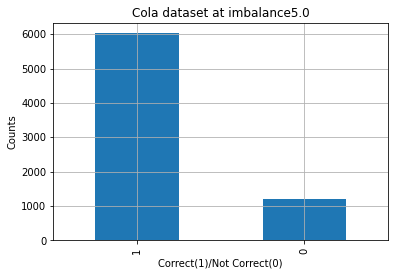

In [ ]:
# Let's plot the imabalnce for train set
df_train_imb["label"].value_counts().plot.bar()
plt.xlabel("Correct(1)/Not Correct(0)")
plt.ylabel("Counts")
plt.title("Cola dataset at imbalance"+str(imbalance_fact))
plt.grid()

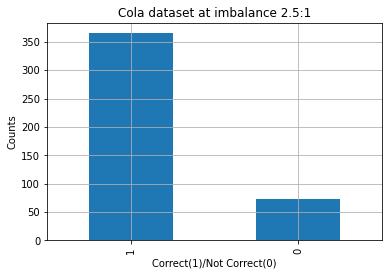

In [ ]:
# Let's plot the imabalnce for test set

df_test_imb["label"].value_counts().plot.bar()
plt.xlabel("Correct(1)/Not Correct(0)")
plt.ylabel("Counts")
plt.title("Cola dataset at imbalance 2.5:1")
plt.grid()

In [ ]:
    embed_size = 128
    inputs = keras.Input(shape=(None,), dtype="int32")
    # Embed each integer in a 128-dimensional vector
    x = layers.Embedding(vocabSize, embed_size)(inputs)
    # Add 2 bidirectional LSTMs
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    # Add a classifier
    outputs = layers.Dense(1, activation="sigmoid")(x)
    imbalanceTest = keras.Model(inputs, outputs)
    imbalanceTest.compile("adam", loss =["BinaryCrossentropy"],metrics=[tf.keras.metrics.Accuracy()],run_eagerly=True)
    imbalanceTest.summary()
    #imbalanceTest.fit(cola_x_train, cola_y_train, batch_size=32, epochs=2,verbose = 1)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,477,761
Trainable params: 1,477,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
imbalanceTest.fit(cola_x_train, cola_y_train, batch_size=32, epochs=2,verbose = 1)

Epoch 1/2
226/226 [==============================] - 85s 376ms/step - loss: 0.4849 - accuracy: 0.0000e+00
Epoch 2/2
226/226 [==============================] - 84s 372ms/step - loss: 0.4169 - accuracy: 0.0000e+00


In [ ]:
cola_y_train

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
df.shape

NameError: ignored

In [ ]:
df_train.shape

(8551, 4)

In [ ]:
cola_x_train = df_train["sentence"].to_numpy()
cola_y_train = df_train["label"].to_numpy()
vocabSize = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=vocabSize,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token=None)
tokenizer.fit_on_texts(cola_x_train)
cola_tensor = tokenizer.texts_to_sequences(cola_x_train)

maxLength = max([len(c) for c in cola_tensor])
print("Cola current sample max length : ",maxLength)

maxLen = 40
cola_tensor = tf.keras.preprocessing.sequence.pad_sequences(cola_tensor,maxlen = maxLen,
                                                         padding='post')

cola_x_train =  cola_tensor

Cola current sample max length :  42


In [ ]:
cola_x_train

array([[ 221,  271,  253, ...,    0,    0,    0],
       [  79,   25, 2634, ...,    0,    0,    0],
       [  79,   25, 2634, ...,    0,    0,    0],
       ...,
       [  14,    6,  180, ...,    0,    0,    0],
       [   5,   39,    1, ...,    0,    0,    0],
       [  43,   53,   22, ...,    0,    0,    0]], dtype=int32)

In [ ]:
cola_x_train.shape

(8551, 40)

In [ ]:
np.unique(cola_y_train)

array([0, 1])

In [ ]:
df_train['label']

0       1
1       1
2       1
3       1
4       1
       ..
8546    0
8547    0
8548    1
8549    1
8550    1
Name: label, Length: 8551, dtype: int64

In [ ]:
imbalanceTest.fit(cola_x_train,cola_y_train,epochs = 2)

Epoch 1/2
268/268 [==============================] - 99s 369ms/step - loss: 0.5152 - accuracy: 0.0000e+00
Epoch 2/2
268/268 [==============================] - 99s 370ms/step - loss: 0.4354 - accuracy: 0.0000e+00


In [ ]:
cola_x_train

array([[ 221,  271,  253, ...,    0,    0,    0],
       [  79,   25, 2634, ...,    0,    0,    0],
       [  79,   25, 2634, ...,    0,    0,    0],
       ...,
       [  14,    6,  180, ...,    0,    0,    0],
       [   5,   39,    1, ...,    0,    0,    0],
       [  43,   53,   22, ...,    0,    0,    0]], dtype=int32)

In [11]:
# IMDB data

class ModifiedMetrics(object):
    """ Metrics class where allt he difference metrics is called as written above, needs to be extended as we 
    collect mroe and more metrics"""
    def __init__(self,threshold = 0.5): # mainly for binary classification now , but to be extedned for multiclass
        self.threshold = threshold             

    def Specificity(self,y_true,y_pred):
        """ TN/(TN+FP) """
        y_pred = np.array([1 if y>self.threshold else 0 for y in y_pred.numpy()])
        y_true = y_true.numpy()
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred,labels=[0,1]).ravel()
        return tn/(tn+fp+1)
    
    def Sensitivity(self,y_true,y_pred):
        """ TP/(TP + FN) """
        y_pred =np.array([1 if y>self.threshold else 0 for y in y_pred.numpy() ])
        y_true = y_true.numpy()
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred,labels = [0,1] ).ravel()
        return tp/(tp+fn+1)

    def modifiedF1Score(self,y_true,y_pred):
        """modified f1 score  """
        y_pred = np.array([1 if y>self.threshold else 0 for y in y_pred.numpy() ])
        y_true = y_true.numpy()
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred,labels = [0,1]).ravel()
        prec = tp/(tp+fp+1)
        recall = tp/(tp+fn+1)
        beta = 1
        modf1score = (1+beta**2)*(prec*recall)/(beta**2*recall + prec)
        return modf1score
        
    def calGmean(self,y_true,y_pred):
        """ G mean function to check harmonic mean Sensitivity and Specificity """
        y_pred = np.array([1 if y>self.threshold else 0 for y in y_pred.numpy() ])
        y_true = y_true.numpy()
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred,labels=[0,1]).ravel()
        return (tp/(tp+fn+1))*(tn/(tn+fp+1))**0.5

    def calMCCCoeff(self,y_true,y_pred):
        """ Mathrews correlation coefficent """
        y_pred = np.array([1 if y>self.threshold else 0 for y in y_pred.numpy()])
        y_true = y_true.numpy()
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred,labels = [0,1]).ravel()
        mcc  =  ((tp*tn) - (fp*fn))/np.sqrt((tp+fp+1)*(tp+fn+1)*(tn+fp+1)*(tn+fn+1))
        return mcc

    def Accuracy(self,y_true,y_pred):
        """ Mathrews correlation coefficent """
        y_pred = np.array([1 if y>self.threshold else 0 for y in y_pred.numpy() ])
        y_true = y_true.numpy()
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred,labels = [0,1]).ravel()
        acc = (tp+tn)/(tp+tn+fp+fn)
        return acc

In [12]:
# Focal Loss
def focal_loss(gamma=2, alpha=0.75):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        #print(pt_1)
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        #print(pt_0)

        #print("first term: ", alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))
        #print("second term:", (1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed 


In [13]:
# class balanced Focal Loss
def classBalancedFocalLoss(y_true,y_pred):
    """ pt = y_pred so for y_true = 1 ,pt = y_pred else 1-y_pred """
    #print("Y_true:",y_true)
    #print("Y_pred",y_pred)
    pt = tf.where(tf.math.equal(y_true,1),y_pred,1-y_pred)
    pt = tf.cast(pt,tf.float64)
    #alpha = 0.24
    numOne =  tf.cast(tf.reduce_sum(tf.where(tf.math.equal(y_true,1),1,0),axis = 0),tf.float64)
    #print("Number of positive Sample ",numOne)
    numZero =  tf.cast(tf.reduce_sum(tf.where(tf.math.equal(y_true,0),1,0),axis = 0),tf.float64)
    #print("Number of negative Sample ",numZero)
    beta = 0.9
    weight = tf.where(tf.math.equal(y_true,1),(1-beta)/(1-beta**numOne),(1-beta)/(1-beta**numZero))
    #print(weight)
    gamma = 2.0
    #weight = tf.where(tf.math.equal(y_true,1),alpha,1-alpha)
    weight = tf.cast(weight,tf.float64)
    #print(pt)
    #print(weight)
    loss = -tf.math.log(pt)*weight*tf.math.pow(1-pt,gamma)
    #print("Loss coming",loss)
    #print("mult",loss)
    total_loss = tf.math.reduce_sum(loss,axis = 0)
    return total_loss 


In [14]:
def LDAMLoss(y_true,y_pred):
    log_odd = tf.cast(tf.math.log(y_pred/(1-y_pred)),tf.float64)
    # marginalized 
    numOne =  tf.cast(tf.reduce_sum(tf.where(tf.math.equal(y_true,1),1,0),axis = 0),tf.float64)
    #print("Number of positive Sample ",numOne)
    numZero =  tf.cast(tf.reduce_sum(tf.where(tf.math.equal(y_true,0),1,0),axis = 0),tf.float64)
    # marginalized log_odds  extra margin 
    margin_logodd = tf.where(tf.math.equal(y_true,1),log_odd - (1.0/numOne**0.25),log_odd-(1.0/numZero**0.25))
    pt = tf.math.sigmoid(margin_logodd)
    #print("changed probablities: ",pt)
    pt = tf.where(tf.math.equal(y_true,1),pt,1-pt)
    loss = -tf.math.log(pt)
    total_loss = tf.math.reduce_sum(loss,axis = 0)
    #print("total loss", total_loss)
    return total_loss


In [15]:
metric = ModifiedMetrics(0.5)

In [ ]:
# IMDB dataset
import keras

max_features = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review

# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
imdb_model = keras.Model(inputs, outputs)
imdb_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=max_features
)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

25000 Training sequences
25000 Validation sequences


In [ ]:
imdb_model.compile("adam", loss = [classBalancedFocalLoss], metrics=["accuracy",metric.calMCCCoeff], run_eagerly = True)
imdb_model.fit(x_train, y_train, batch_size=128, epochs=2, validation_data= (x_val,y_val))

Epoch 1/2
196/196 [==============================] - 71s 364ms/step - loss: 1.2721 - accuracy: 0.8177 - calMCCCoeff: 0.6256 - val_loss: 1.0082 - val_accuracy: 0.8736 - val_calMCCCoeff: 0.7244
Epoch 2/2
196/196 [==============================] - 72s 370ms/step - loss: 0.6080 - accuracy: 0.9354 - calMCCCoeff: 0.8444 - val_loss: 1.3604 - val_accuracy: 0.8364 - val_calMCCCoeff: 0.6665


In [36]:
# Cola DataSet 
!pip install transformers


     |████████████████████████████████| 1.9MB 8.1MB/s 
     |████████████████████████████████| 3.2MB 52.9MB/s 
     |████████████████████████████████| 890kB 52.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=025d89c8ce8edc0637808c121c07a760a5d5e4373b42d0593f29e325b8f8b029
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [16]:
from transformers import BertTokenizer
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


Loading BERT tokenizer...


In [17]:
label = df_train.label.values
sentences = df_train.sentence.values

In [18]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


In [19]:
max_length = 40
encoded = tokenizer.batch_encode_plus(
            sentences,
            padding = 'longest',
        )


In [20]:
input_ids = np.array(encoded["input_ids"],dtype = "int32")
att_mask =  np.array(encoded["attention_mask"],dtype="int32")

In [21]:
att_mask.shape

(8551, 47)

In [22]:
# BERT MODEL 
from transformers import TFBertModel
np.random.seed(4)
max_length = 47



def createModel():
  """ create the model for COLA with BERT Tokenizer """
  input_ids = tf.keras.layers.Input(
          shape=(max_length,), dtype=tf.int32, name="input_ids")
      # Attention masks indicates to the model which tokens should be attended to.
  attention_masks = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_masks")
      # Token type ids are binary masks identifying different sequences in the model.
  bert_model = TFBertModel.from_pretrained("bert-base-uncased")
      # Freeze the BERT model to reuse the pretrained features without modifying them.
  bert_model.trainable = False
  bert_out = bert_model(input_ids, attention_mask=attention_masks)
  print(bert_out)
  sequence_output = bert_out["last_hidden_state"]
  print(sequence_output)
  # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
  bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(sequence_output)
      # Applying hybrid pooling approach to bi_lstm sequence output.
  avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
  max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
  concat = tf.keras.layers.concatenate([avg_pool, max_pool])
  dropout = tf.keras.layers.Dropout(0.3)(concat)
  output = tf.keras.layers.Dense(1, activation="sigmoid")(dropout)
  model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
  model.compile(optimizer=tf.keras.optimizers.Adam(),
          loss=[classBalancedFocalLoss],
          metrics=["accuracy",metric.calMCCCoeff],run_eagerly= True)

  model.summary()
  return model


In [23]:
cola_bert = createModel()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

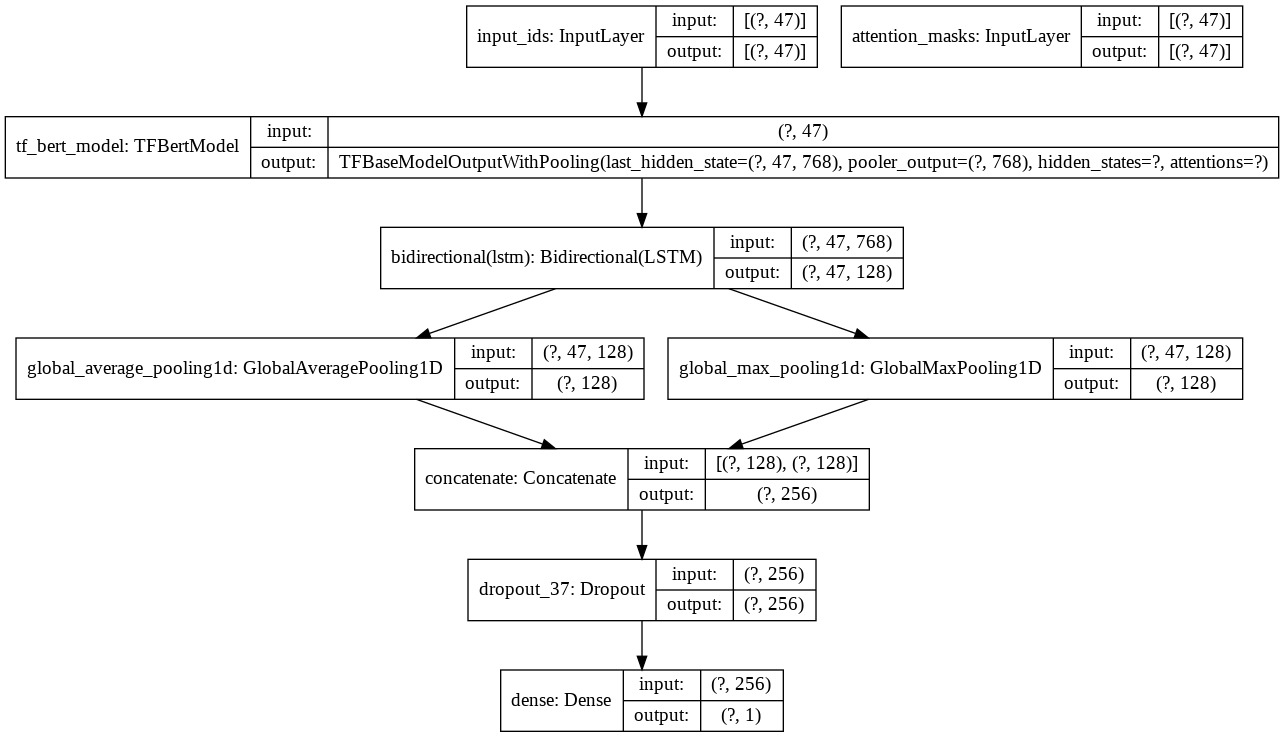

In [24]:
tf.keras.utils.plot_model(cola_bert,show_shapes=True)

In [ ]:
cola_bert.fit(x = [input_ids,att_mask], y = label, batch_size = 32,  epochs = 5 )

Epoch 1/5
 26/268 [=>............................] - ETA: 1:45 - loss: 0.6424 - accuracy: 0.6863 - calMCCCoeff: 0.0686

KeyboardInterrupt: ignored

In [25]:
test_label = df_test.label.values
test_sentences = df_test.sentence.values

In [26]:
 max_length = 47
 encoded = tokenizer.batch_encode_plus(
            test_sentences,
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [27]:
test_input_ids = np.array(encoded["input_ids"],dtype = "int32")
test_att_mask =  np.array(encoded["attention_mask"],dtype="int32")

In [28]:
y_pred = cola_bert.predict([test_input_ids,test_att_mask])

In [29]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience= 2)
model_hist = cola_bert.fit(x = [input_ids,att_mask], y = label, batch_size = 32,  epochs = 15, validation_data = ([test_input_ids,test_att_mask],test_label),callbacks = [early_stopping])

Epoch 1/15
268/268 [==============================] - 95s 356ms/step - loss: 0.6142 - accuracy: 0.7067 - calMCCCoeff: 0.2383 - val_loss: 0.5415 - val_accuracy: 0.7647 - val_calMCCCoeff: 0.3322
Epoch 2/15
268/268 [==============================] - 95s 354ms/step - loss: 0.5591 - accuracy: 0.7504 - calMCCCoeff: 0.3253 - val_loss: 0.5597 - val_accuracy: 0.7666 - val_calMCCCoeff: 0.2939
Epoch 3/15
268/268 [==============================] - 95s 353ms/step - loss: 0.5394 - accuracy: 0.7608 - calMCCCoeff: 0.3507 - val_loss: 0.5371 - val_accuracy: 0.7780 - val_calMCCCoeff: 0.3336
Epoch 4/15
268/268 [==============================] - 94s 353ms/step - loss: 0.5126 - accuracy: 0.7773 - calMCCCoeff: 0.3914 - val_loss: 0.5860 - val_accuracy: 0.7685 - val_calMCCCoeff: 0.2939
Epoch 5/15
268/268 [==============================] - 95s 353ms/step - loss: 0.4941 - accuracy: 0.7835 - calMCCCoeff: 0.4058 - val_loss: 0.5272 - val_accuracy: 0.7818 - val_calMCCCoeff: 0.3576
Epoch 6/15
268/268 [===============

In [ ]:
cola_bert.layers

In [36]:
bert_model = cola_bert.layers[2]

In [37]:
bert_model.trainable = True

In [38]:
cola_bert.layers[2].trainable = True

In [39]:
model_hist = cola_bert.fit(x = [input_ids,att_mask], y = label, batch_size = 32,  epochs = 15, validation_data = ([test_input_ids,test_att_mask],test_label),callbacks = [early_stopping])

Epoch 1/15
268/268 [==============================] - 96s 358ms/step - loss: 0.4240 - accuracy: 0.8227 - calMCCCoeff: 0.4929 - val_loss: 0.6288 - val_accuracy: 0.7704 - val_calMCCCoeff: 0.3074
Epoch 2/15
268/268 [==============================] - 95s 356ms/step - loss: 0.4087 - accuracy: 0.8311 - calMCCCoeff: 0.5101 - val_loss: 0.5417 - val_accuracy: 0.7989 - val_calMCCCoeff: 0.4058
Epoch 3/15
268/268 [==============================] - 95s 355ms/step - loss: 0.3914 - accuracy: 0.8435 - calMCCCoeff: 0.5365 - val_loss: 0.6032 - val_accuracy: 0.7932 - val_calMCCCoeff: 0.3923
Epoch 4/15
268/268 [==============================] - 95s 355ms/step - loss: 0.3684 - accuracy: 0.8496 - calMCCCoeff: 0.5530 - val_loss: 0.6836 - val_accuracy: 0.7742 - val_calMCCCoeff: 0.3373
